# Classification Origin

Papers:

https://www.semanticscholar.org/paper/Music-and-Geography%3A-Content-Description-of-Musical-G%C3%B3mez-Haro/4d48f2eaefc6a8336149e4cca1c5d2264969f223#paper-topics



In [25]:
import csv
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # Import the colormap module
import folium
from scipy.spatial import Voronoi
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing



In [26]:
music_origin_data = pd.read_csv('./data/kaggle/Music_origin.csv')
music_origin_cr_data = pd.read_csv('./data/kaggle/Music_origin_chromatic.csv')
gdf_bondaries = gpd.read_file('./data/countries/world-administrative-boundaries.shp')

music_origin_data.drop('Unnamed: 0',axis=1,inplace=True)
music_origin_cr_data.drop('Unnamed: 0',axis=1,inplace=True)

C:\Users\claud\AppData\Local\Temp\ipykernel_19084\229727454.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


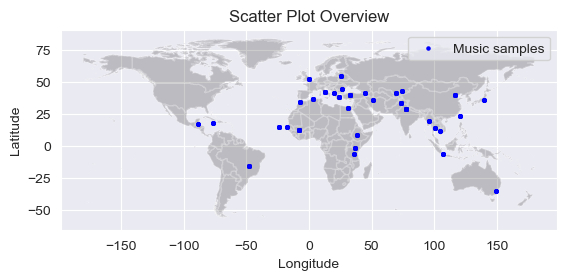

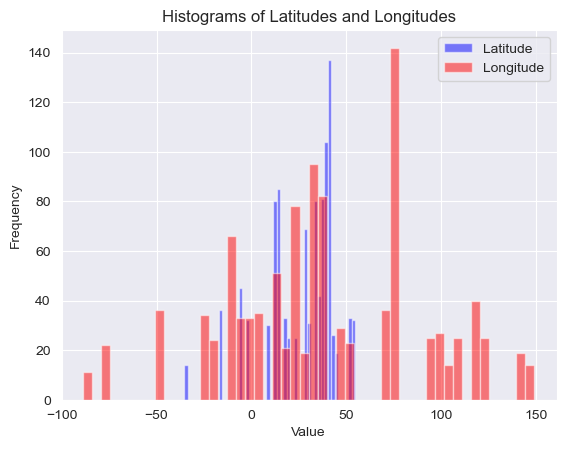

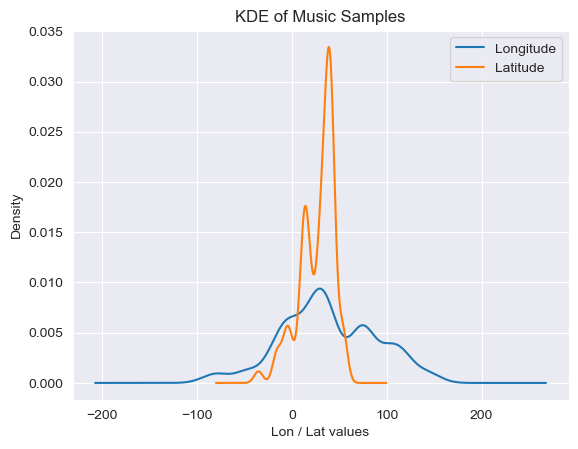

In [27]:
with open('./data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))




gdf_bondaries.plot(ax=plt.gca(), color='black', alpha=0.2, label='Shapefile')
plt.scatter(music_origin_data["Longitude"], music_origin_data["Latitude"], s=5, color = "blue",label = 'Music samples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot Overview')
plt.legend()
plt.show()


plt.hist(music_origin_data["Latitude"], bins=50, alpha=0.5, color='blue', label='Latitude')
plt.hist(music_origin_data["Longitude"], bins=50, alpha=0.5, color='red', label='Longitude')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histograms of Latitudes and Longitudes')
plt.show()



music_origin_data[["Longitude","Latitude"]].plot.kde()
plt.xlabel('Lon / Lat values')
plt.title('KDE of Music Samples')
plt.show()

In [28]:
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster


geometry = [Point(xy) for xy in zip(music_origin_data['Longitude'], music_origin_data['Latitude'])]
music_origin_gdf = gpd.GeoDataFrame(music_origin_data, geometry=geometry, crs="EPSG:4326")
music_origin_gdf = gpd.sjoin(music_origin_gdf, gdf_bondaries, how="left", op="within")
unmatched_points = music_origin_gdf[music_origin_gdf['iso3'].isna()].copy()

for idx, point in unmatched_points.iterrows():
    point_geom = point['geometry']
    nearest_polygon_idx = gdf_bondaries.geometry.distance(point_geom).idxmin()
    nearest_polygon_attributes = gdf_bondaries.loc[nearest_polygon_idx]
    nearest_polygon_attributes['geometry'] = point_geom
    music_origin_gdf.loc[idx, music_origin_gdf.columns.intersection(nearest_polygon_attributes.index)] = nearest_polygon_attributes

music_origin_gdf = music_origin_gdf.drop(columns=['index_right']).rename(columns={'index_left': 'index'})


C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\claud\AppData\Local\Temp\ipykernel_19084\2858131190.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_polygon_idx = gdf_bondaries.geometry.distance(point_geom).idxmin()
C:\Users\claud\AppData\Local\Temp\ipykernel_19084\2858131190.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearest_polygon_attributes['geometry'] = point_geom
C:\Users\claud\AppData\Local\Temp\ip

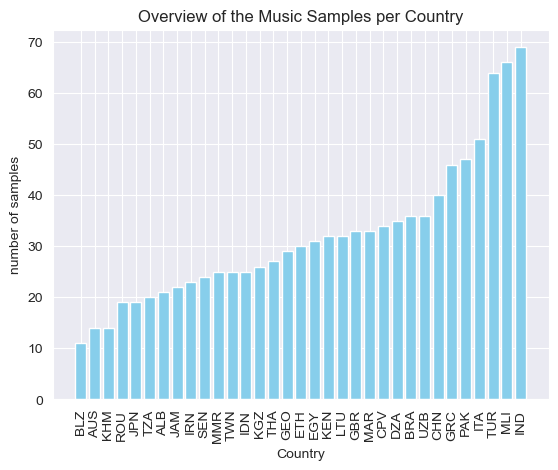

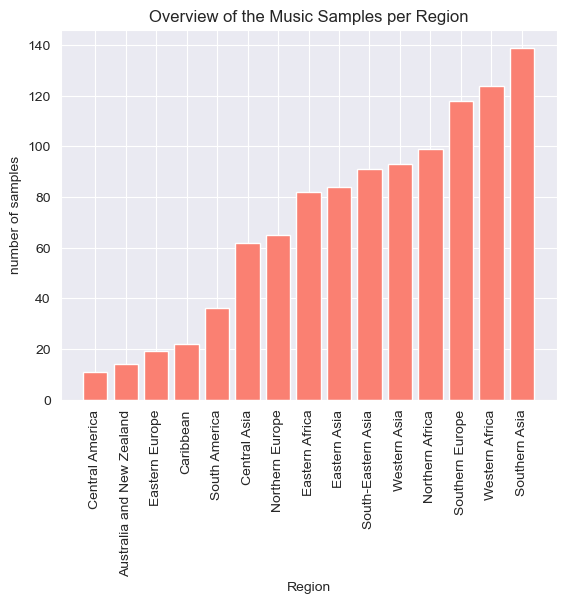

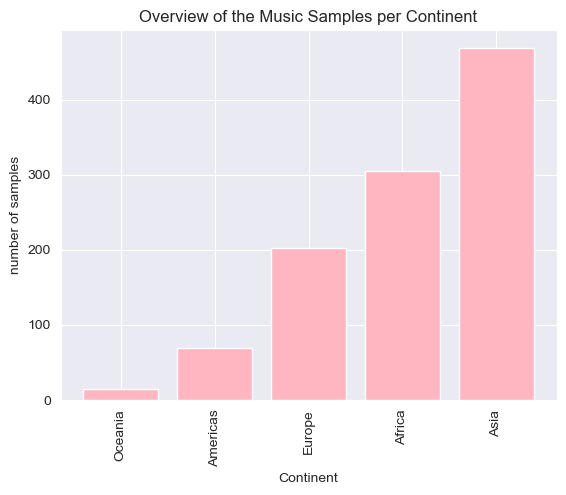

In [29]:
per_country = music_origin_gdf.groupby('iso3').nunique().reset_index().sort_values('Feature1')
plt.bar(per_country["iso3"],per_country["Feature1"], color = "skyblue")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Country")
plt.ylabel("number of samples")
plt.xlabel("Country")
plt.show()

per_region = music_origin_gdf.groupby('region').nunique().reset_index().sort_values('Feature1')
plt.bar(per_region["region"],per_region["Feature1"], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.show()

per_continent = music_origin_gdf.groupby('continent').nunique().reset_index().sort_values('Feature1')
plt.bar(per_continent["continent"],per_continent["Feature1"], color = "lightpink")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Continent")
plt.ylabel("number of samples")
plt.xlabel("Continent")
plt.show()

# Have a Look at the 68 Features

Text(0.5, 1.0, 'Boxplot of all Features of the Music Dataset')

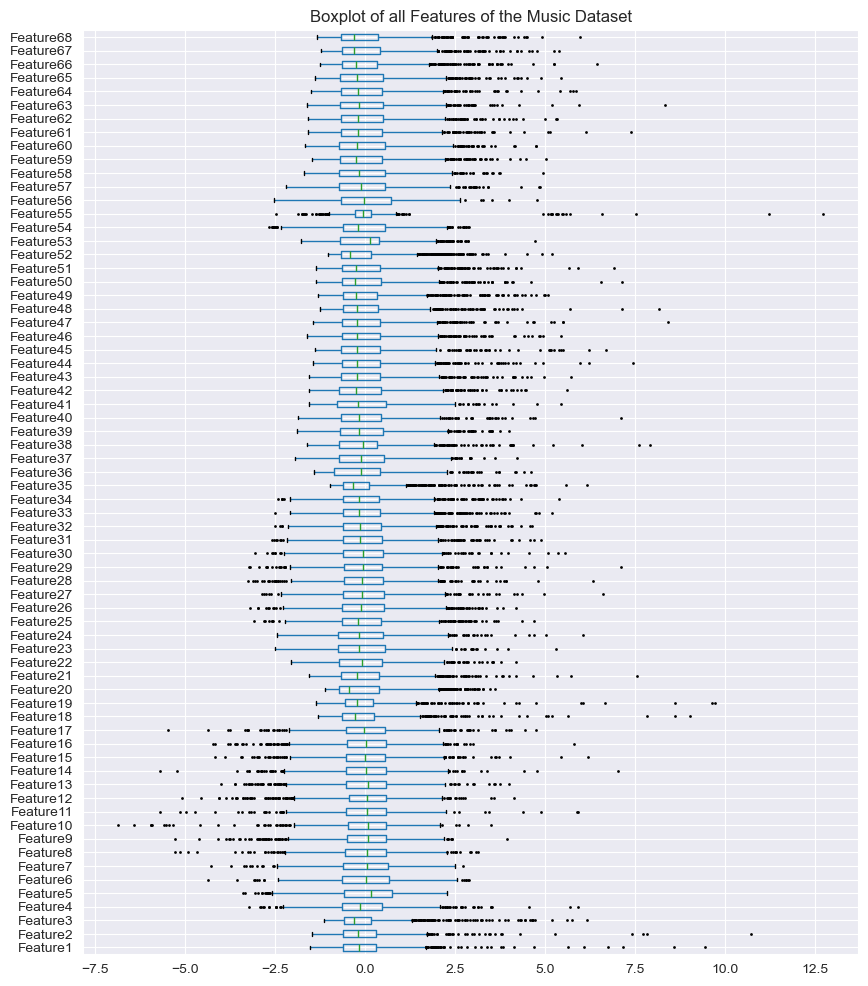

In [30]:
plt.figure(figsize=(10, 12))
music_origin_gdf.drop(['Latitude', 'Longitude', 'geometry', 'iso3',
                        'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                        'french_shor'],axis=1).boxplot(vert=False,
                                                       flierprops={'marker': 'o', 'markersize': 1})

plt.title("Boxplot of all Features of the Music Dataset")

There are alot of features, thus it could be an idea, to make a Principle Component Analysis to reduce the number of features.

# PCA

In [31]:
#make PCA:
scaler = preprocessing.StandardScaler()
music_origin_gdf_scaled = scaler.fit_transform(music_origin_gdf.drop(['Latitude', 'Longitude', 'geometry', 'iso3',
                                                                      'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                                                                      'french_shor'],axis=1))
nums = np.arange(68)
var_ratio = []
for num in nums:
    pca = PCA(n_components=num).fit(music_origin_gdf_scaled)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check 

Text(3, 0.15, '20% cut-off')

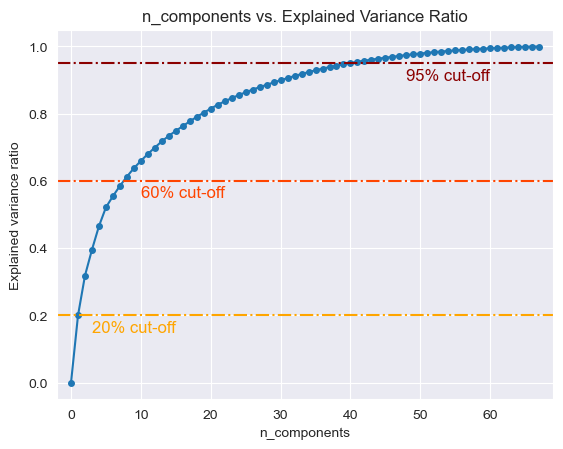

In [32]:
plt.plot(nums,var_ratio,marker='o',markersize = 4)
plt.xlim(-2,69)
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
plt.axhline(y=0.95, color='darkred', linestyle='-.')
plt.text(48, 0.9, '95% cut-off', color = 'darkred', fontsize=12)
plt.axhline(y=0.6, color='orangered', linestyle='-.')
plt.text(10, 0.55, '60% cut-off ', color = 'orangered', fontsize=12)
plt.axhline(y=0.2, color='orange', linestyle='-.')
plt.text(3, 0.15, '20% cut-off', color = 'orange', fontsize=12)

Okay, we choose the 95% cut-off beacuse then we have 95% of the variance explained, which is quite good.

Number of components to reach 95% cutoff: 41
Number of components to reach 60% cutoff: 9
Number of components to reach 20% cutoff: 3


Text(0.5, 1.0, 'Boxplot of all Features of the Music Dataset after PCA')

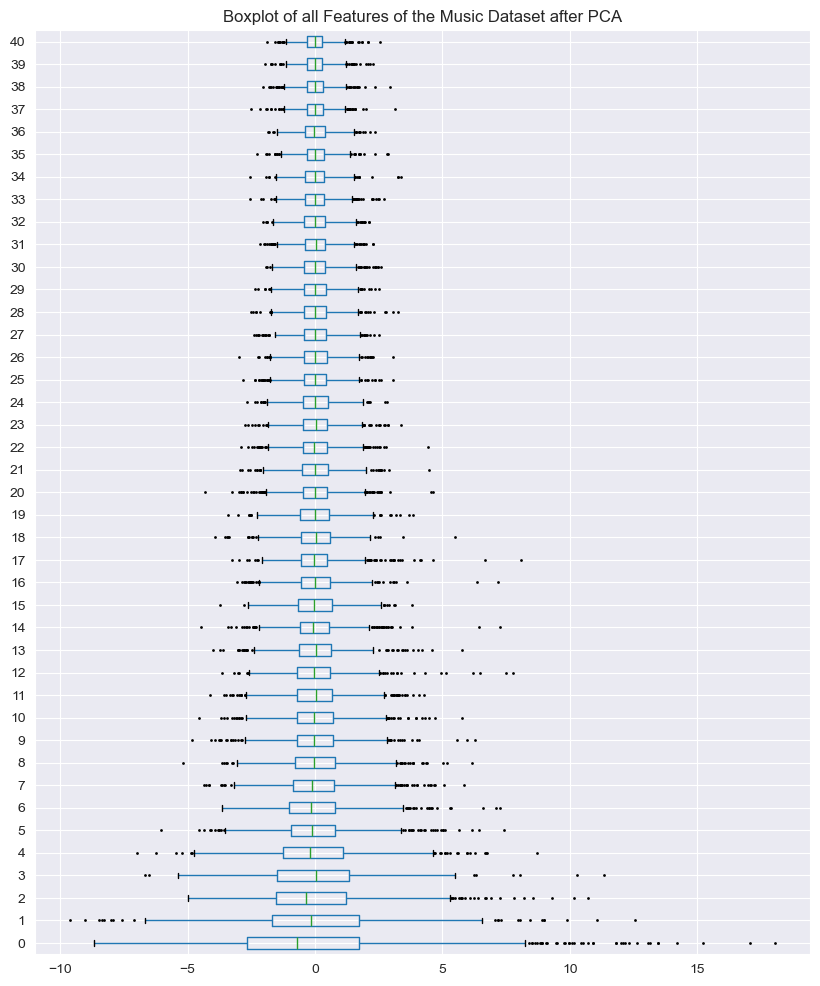

In [33]:
def get_num_components(percent,var_ratio = var_ratio):
    num_components_XX_percent = np.argmax(np.array(var_ratio) >= percent/100) + 1
    #print(f"Number of components to reach {percent}% cutoff: {num_components_XX_percent}")
    return num_components_XX_percent

print(f"Number of components to reach 95% cutoff: {get_num_components(95)}")
print(f"Number of components to reach 60% cutoff: {get_num_components(60)}")
print(f"Number of components to reach 20% cutoff: {get_num_components(20)}")

#make PCA with 95% cutoff
music_origin_pca= pd.DataFrame(PCA(n_components=get_num_components(95)).fit_transform(music_origin_gdf_scaled))
music_origin_gdf_pca = music_origin_pca.merge(music_origin_gdf.loc[:,['Latitude', 'Longitude', 'iso3',
                                                                          'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                                                                          'french_shor']], left_index=True, right_index=True)


plt.figure(figsize=(10, 12))
music_origin_pca.boxplot(vert=False, flierprops={'marker': 'o', 'markersize': 1})

plt.title("Boxplot of all Features of the Music Dataset after PCA")

# Clustering

To make this problem to a classification problem, we have to define clusters in order to classify the music samples

## Manual Clustering (geographic boundaries made by humans)

In [34]:
#By region
gdf_regions = gdf_bondaries.dissolve(by='region')
gdf_regions["region"] = gdf_regions.index
gdf_regions1 = gdf_regions[gdf_regions["region"].isin(music_origin_gdf_pca.region.unique())]

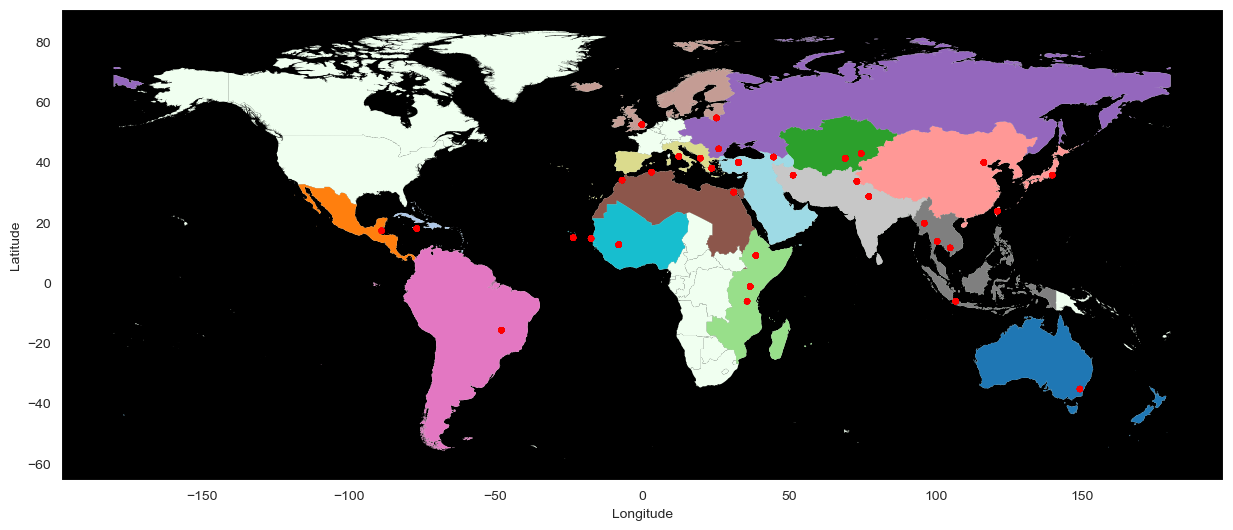

In [35]:
plt.figure(figsize=(15,15))
gdf_bondaries.plot(ax=plt.gca(), color = "honeydew",edgecolor = "none")
gdf_regions1.plot(ax=plt.gca(), column='region', cmap="tab20", alpha=1, legend=False, label='World Regions',edgecolor = "none")
plt.scatter(music_origin_data["Longitude"], music_origin_data["Latitude"], s=20, color = "red",label = 'Music samples',edgecolor = "none")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().set_facecolor("black")
plt.grid(False)

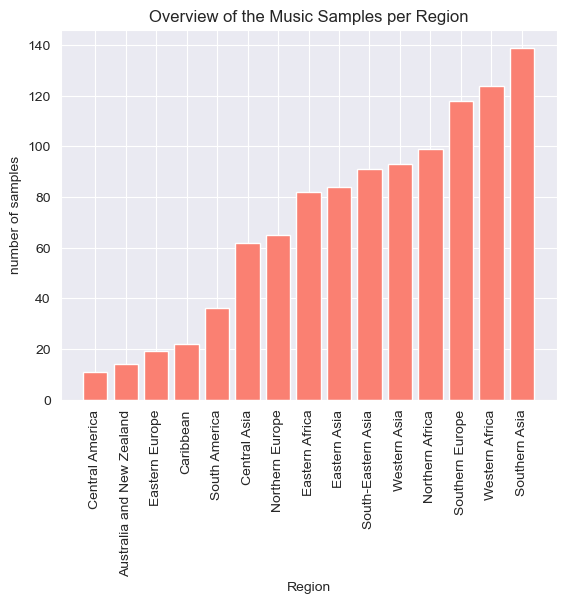

In [36]:
per_region = music_origin_gdf_pca.groupby('region').nunique().reset_index().sort_values(1)
plt.bar(per_region["region"],per_region[1], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.show()

As seen here, we can see that the clusters are not equally distributed, which can lead to a false good prediction, because the chances that it lies in southern Asia is about the same. We try now to DBSCAN the points to clusters.

## Automatic Clustering (DBScan Method)

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check 

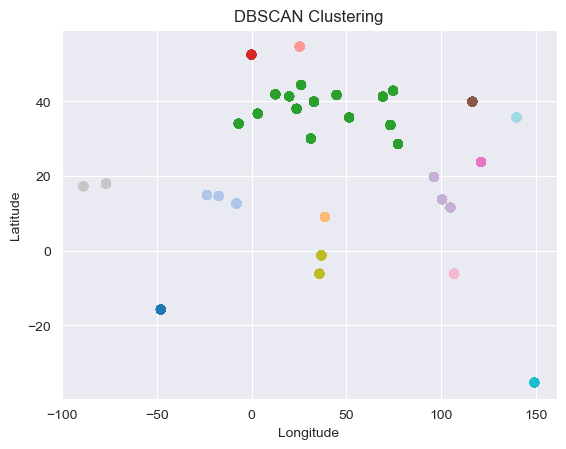

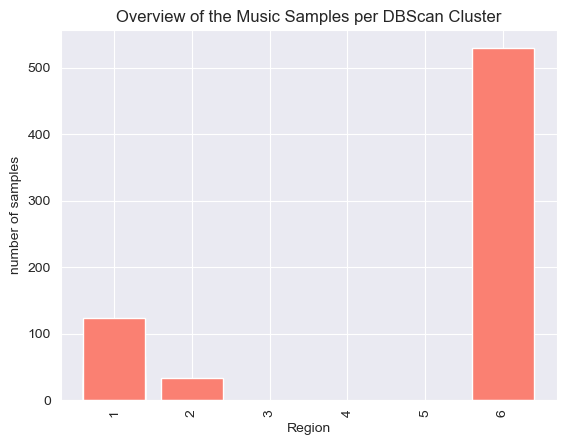

In [37]:
# Standardize the data
from sklearn.cluster import DBSCAN
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(music_origin_gdf_pca[["Longitude","Latitude"]])

dbscan = DBSCAN(eps=0.5, min_samples=2)  # You may need to adjust eps and min_samples
music_origin_gdf_pca['Cluster'] = dbscan.fit_predict(scaled_data)

music_origin_gdf_pca.head()

plt.scatter(music_origin_data['Longitude'], music_origin_data['Latitude'], c=music_origin_gdf_pca['Cluster'], cmap='tab20')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')
plt.show()



per_DBCluster = music_origin_gdf_pca.groupby('Cluster').nunique().reset_index().sort_values(1)
plt.bar(per_DBCluster["region"],per_DBCluster[1], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per DBScan Cluster")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.show()
# 
# music_origin_gdf_pca


# Classification

In [ ]:
from sklearn.model_selection import train_test_split
from datetime import datetime, timezone
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
import catboost as cb

music_origin_gdf_pca_ml = music_origin_gdf_pca.drop(['Latitude', 'Longitude',
                                                      'status', 'color_code', 'name', 'iso3', 'iso_3166_1_',
                                                      'french_shor','continent','Cluster'],axis = 1)


start_time = datetime.now()

X_train, X_test, y_train, y_test = train_test_split(music_origin_gdf_pca_ml.drop("region",axis = 1), music_origin_gdf_pca_ml['region'], test_size=0.2)



param_grid = {
    'iterations': [20],
    'depth': [9],
'learning_rate': [0.2]
}
#define the scorer, in this case we can use the mean squared error:
scorer = make_scorer(accuracy_score)


rfc = cb.CatBoostClassifier()

#make the GridSearch:

grid_search = GridSearchCV(
estimator=rfc,
param_grid=param_grid,
scoring=scorer,
cv=5,
n_jobs=-1,
refit='mse',
verbose=10,
)

grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_



end_time = datetime.now()
print(f'Finished in: {end_time-start_time}')

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_accuracy)

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Fitting 5 folds for each of 1 candidates, totalling 5 fits


# Idea: SMOTE
The classes are quite inbalanced. So there exist more insstances in class X than in class Y. An option is to syntheticly generate data for the less representative class. perhaps this could improve the classes?
1. -> create artificial datapoints to train the data accordingly good
2. Train the model with the artificial points
3. Test set is the old set!


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
per_region = pd.DataFrame(y_train_resampled.value_counts()).reset_index()
plt.bar(per_region["region"], per_region['count'], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region (SMOTE)")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.show()

In [ ]:
start_time = datetime.now()
grid_search.fit(X_train_resampled,y_train_resampled)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_accuracy = grid_search.best_score_
end_time = datetime.now()
print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_accuracy)
print(f'Finished in: {end_time-start_time}')
